In [1]:
# Find the cross correlation for all areas with all factors
# Identify for building, land and condo
# Sort all areas by cross correlation peak value
# Identify what is a relevant peak value


In [2]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from jre_utils.config import asset_types
from jre_utils.visualize import plot_time_series
from jre_utils.process import get_cumulative_growth, get_cumulative_growth_from_base

from jre_utils.datapath import (
    factor_data_paths,
    model_built_data_paths,
    get_derived_csv_path,
    get_derived_lpa_path,
    get_derived_plps_path,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
asset_type = "condo"
years_ahead = 2

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

dataset_paths = {
    "transactions": get_derived_csv_path(asset_type),
    "lpa": get_derived_lpa_path(),
    "plps": get_derived_plps_path()
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

# metric_key_unsmoothed = "weighted_median"
metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

metric_key = f"{metric_key_unsmoothed}_smoothed"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric


In [4]:
dataset_key = "transactions"
core_path = dataset_paths[dataset_key]
population_path = factor_data_paths["processed"]["population"]["municipality"]
migration_path = factor_data_paths["processed"]["migration"]["municipality"]
taxable_income_path = factor_data_paths["processed"]["taxable_income"]["municipality"]
new_dwellings_path = factor_data_paths["processed"]["new_dwellings"]["municipality"]
lfs_revenue_path = factor_data_paths["processed"]["lfs_revenue_breakdown"]["municipality"]

dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
model_built_data_path = model_built_data_paths[dataset_name]

In [5]:
df = pd.read_csv(core_path)
df = df.assign(asset_type=asset_type)

population_df = pd.read_csv(population_path)
migration_df = pd.read_csv(migration_path)
taxable_income_df = pd.read_csv(taxable_income_path)
new_dwellings_df = pd.read_csv(new_dwellings_path)
lfs_revenue_df= pd.read_csv(lfs_revenue_path)

df = (
    df.merge(population_df, on=group_by_columns, how="left")
    .merge(migration_df, on=group_by_columns, how="left")
    .merge(taxable_income_df, on=group_by_columns, how="left")
    .merge(new_dwellings_df, on=group_by_columns, how="left")
    .merge(lfs_revenue_df, on=group_by_columns, how="left")
)

In [116]:
# prepare additional factors
df = df.sort_values(by=group_by_columns, ascending=True)
df["count_growth"] = df.groupby(granularity_columns)["count"].pct_change()
df["yearly_price_growth_unsmoothed"] = df.groupby(granularity_columns)[metric_unsmoothed].pct_change()
df["yearly_price_growth_smoothed"] = df.groupby(granularity_columns)[metric].pct_change()

In [148]:
area_code = 13101
area_df = df[df["area_code"] == area_code].sort_values(by="year", ascending=True)

In [149]:
area_df[granularity_columns + ["year", metric, metric_unsmoothed, "yearly_price_growth_unsmoothed", "yearly_price_growth_smoothed"]]

,area,area_code,year,unit_price_median_smoothed,unit_price_median,yearly_price_growth_unsmoothed,yearly_price_growth_smoothed
151,Tokyo-to Chiyoda-ku,13101,2005,1.000000e+06,1.000000e+06,NaN,NaN
152,Tokyo-to Chiyoda-ku,13101,2006,8.000000e+05,8.000000e+05,-0.200000,-0.200000
153,Tokyo-to Chiyoda-ku,13101,2007,8.571429e+05,8.571429e+05,0.071429,0.071429
154,Tokyo-to Chiyoda-ku,13101,2008,8.670330e+05,8.670330e+05,0.011538,0.011538
155,Tokyo-to Chiyoda-ku,13101,2009,7.800000e+05,7.800000e+05,-0.100380,-0.100380
156,Tokyo-to Chiyoda-ku,13101,2010,8.000000e+05,8.000000e+05,0.025641,0.025641
157,Tokyo-to Chiyoda-ku,13101,2011,8.000000e+05,8.000000e+05,0.000000,0.000000
158,Tokyo-to Chiyoda-ku,13101,2012,8.125000e+05,8.000000e+05,0.000000,0.015625
159,Tokyo-to Chiyoda-ku,13101,2013,8.250000e+05,8.250000e+05,0.031250,0.015385
160,Tokyo-to Chiyoda-ku,13101,2014,9.124993e+05,9.500000e+05,0.151515,0.106060


In [150]:
growth_variables = [
    # "yearly_price_growth_unsmoothed",
    # "yearly_price_growth_smoothed",
    "taxable_income_growth",
    "total_tax_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
    "count_growth"
]

variables_to_compare = [
    "yearly_price_growth_unsmoothed",
    # "yearly_price_growth_smoothed",
    "taxable_income_growth",
    "count_growth"
]

for variable in variables_to_compare:
    plot_time_series(
        area_df,
        variable,
        group_by_columns,
        granularity_columns,
        f"{variable} over time",
        width=1000,
        height=400,
        showlegend=False,
        # visible="legendonly",
        # highlight=True,
        # highlight_range=(2020, 2022)
    )

In [144]:
cross_correlation_dict = {
    area_code: {
        dep: {
            factor: {"lag": [], "corr": [], "corr_norm": []}
            for factor in growth_variables
            + ["yearly_price_growth_unsmoothed", "yearly_price_growth_smoothed"]
        }
        for dep in ["yearly_price_growth_unsmoothed", "yearly_price_growth_smoothed"]
    }
    for area_code in df["area_code"].unique()
}

for area_code in df["area_code"].unique():
    area_df = df[df["area_code"] == area_code].sort_values(by="year", ascending=True)
    for dep in ["yearly_price_growth_unsmoothed", "yearly_price_growth_smoothed"]:
        for factor in growth_variables:
            corr_df = area_df[["year", dep, factor]].set_index("year").dropna()
            dep_curve = corr_df[dep]
            factor_curve = corr_df[factor]

            if len(corr_df) > 0:
                # Lags
                lags = np.arange(-len(dep_curve) + 1, len(dep_curve))

                # Cross Corr
                cross_corr = np.correlate(dep_curve, factor_curve, mode="full")

                # Normalize Cross Corr
                auto_corr_x = np.correlate(dep_curve, dep_curve, mode="full")[
                    len(corr_df[dep]) - 1
                ]
                auto_corr_y = np.correlate(factor_curve, factor_curve, mode="full")[
                    len(corr_df[factor]) - 1
                ]

                normalization_factor = np.sqrt(auto_corr_x * auto_corr_y)
                cross_corr_normalized = cross_corr / normalization_factor

                # Store
                cross_correlation_dict[area_code][dep][factor]["lag"] = lags
                cross_correlation_dict[area_code][dep][factor]["corr"] = cross_corr
                cross_correlation_dict[area_code][dep][factor][
                    "corr_norm"
                ] = cross_corr_normalized

In [ ]:
# For each prefecture, find the average corr_norm for each factor
# Find the average for all of japan

dep = "yearly_price_growth_unsmoothed"
for factor in growth_variables + ["yearly_price_growth_unsmoothed", "yearly_price_growth_smoothed"]:
    np.sum()
    

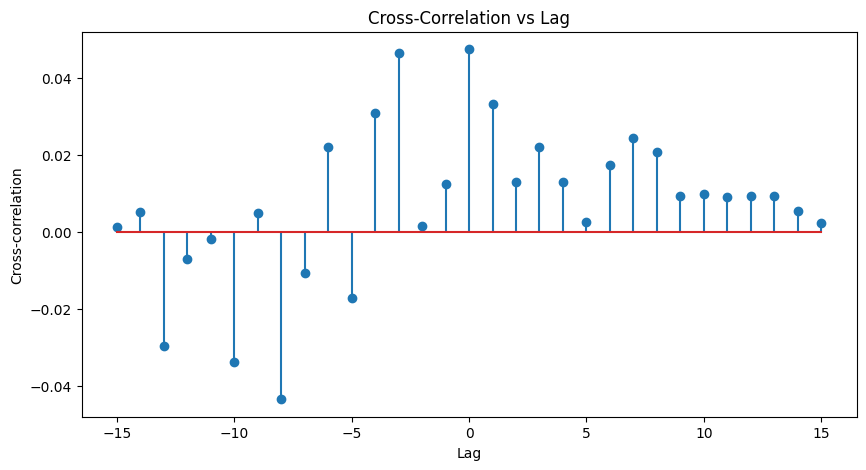

In [151]:
area_code = 13101
x_var = "yearly_price_growth_unsmoothed"
y_var = "taxable_income_growth"

cross_corr = cross_correlation_dict[area_code][x_var][y_var]["corr"]
cross_corr_norm = cross_correlation_dict[area_code][x_var][y_var]["corr_norm"]
lags = cross_correlation_dict[area_code][x_var][y_var]["lag"]


# Plotting the cross-correlation vs lags
plt.figure(figsize=(10, 5))
plt.stem(lags, cross_corr)
plt.title('Cross-Correlation vs Lag')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.show()

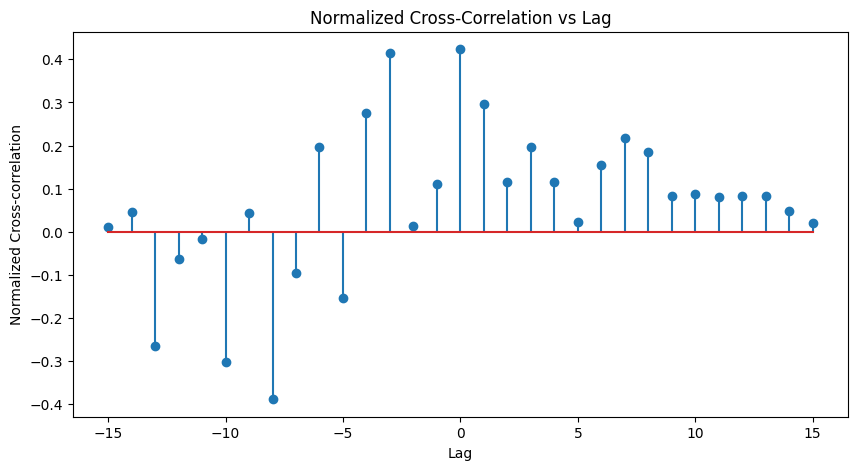

In [152]:
plt.figure(figsize=(10, 5))
plt.stem(lags, cross_corr_norm)
plt.title('Normalized Cross-Correlation vs Lag')
plt.xlabel('Lag')
plt.ylabel('Normalized Cross-correlation')
plt.show()

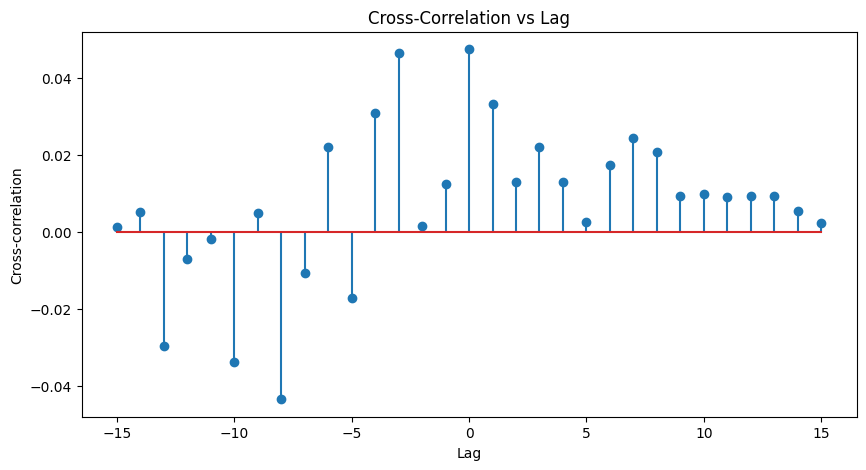

In [153]:
x_var = "yearly_price_growth_unsmoothed"
y_var = "taxable_income_growth"

corr_df = area_df[["year", x_var, y_var]].set_index("year").dropna()

x = corr_df[x_var]
y = corr_df[y_var]

# Compute the cross-correlation between x and y
cross_corr = np.correlate(x, y, mode='full')

lags = np.arange(-len(x) + 1, len(x))

# Plotting the cross-correlation vs lags
plt.figure(figsize=(10, 5))
plt.stem(lags, cross_corr)
plt.title('Cross-Correlation vs Lag')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.show()

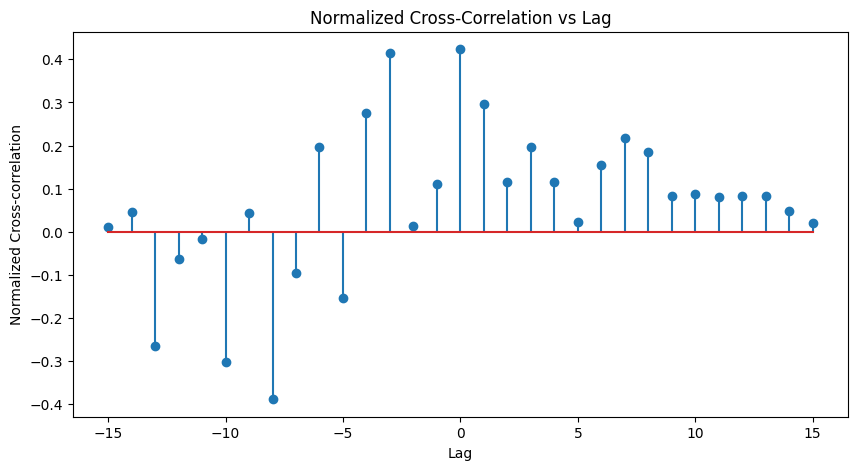

In [154]:
# Auto-correlation of each series at lag 0 (used for normalization)
auto_corr_x = np.correlate(x, x, mode='full')[len(x)-1]
auto_corr_y = np.correlate(y, y, mode='full')[len(y)-1]

# Normalization factor
normalization_factor = np.sqrt(auto_corr_x * auto_corr_y)

# Normalized cross-correlation
cross_corr_normalized = cross_corr / normalization_factor

# Plotting the normalized cross-correlation vs lags
plt.figure(figsize=(10, 5))
plt.stem(lags, cross_corr_normalized)
plt.title('Normalized Cross-Correlation vs Lag')
plt.xlabel('Lag')
plt.ylabel('Normalized Cross-correlation')
plt.show()